In [1]:
import pandas as pd
import os
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append('/cellar/users/snwright/Git/Network_Evaluation_Tools/neteval/')

# SetUP


In [2]:
datadir='/cellar/users/snwright/Data/RareCommon'
refdir='/cellar/users/snwright/Data/RareCommon/Reference/'
outdir='/cellar/users/snwright/Data/RareCommon/Annotations'
figdir='/cellar/users/snwright/Data/Transfer/RVC/figures/AnnotationAnalysis'
featuredir='/cellar/users/snwright/Data/RareCommon/outputs/Features'

In [3]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.size':8})
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.4
plt.rcParams['ytick.major.width'] = 0.4
plt.rcParams['xtick.minor.width'] = 0.3
plt.rcParams['ytick.minor.width'] = 0.3
plt.rcParams['legend.frameon'] = False
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['ytick.minor.size'] = 2
plt.rcParams['xtick.major.pad'] = 1
plt.rcParams['ytick.major.pad'] = 1
plt.rcParams['axes.labelpad'] = 1
plt.rcParams['patch.linewidth'] = 0.25

In [5]:
files = {
    'Cite':'Gene_Citation_Dec23.txt', 'MisSyn': 'Gene_MisSyn.txt', 
    'Disgen':'Gene_disgen.txt', 'pli': 'Gene_pLI.txt',
    'dgi': 'Gene_DGI_scores.txt', 'omim': 'Gene_OMIM.txt', 
    'Length': 'Gene_length.txt', 'Prot': 'Gene_prot.txt',
    'GO': 'Gene_GO.txt' , 'phylop': 'Gene_PhyloP.txt',
    'mrna':'Gene_mRNA.txt'
}

annot_dir = '/cellar/users/snwright/Data/RareCommon/Annotations'

In [6]:
transform = {'Cite': np.log10,
 'MisSyn': None,
 'Disgen': np.log10,
 'pli': None,
 'dgi': np.log10,
 'omim': np.log10,
 'Length': np.log10,
 'Prot': None,
 'GO': np.log10,
 'phylop': None,
 'mrna': np.log10}

metric = {'Cite': np.median,
 'MisSyn': np.mean,
 'Disgen': np.median,
 'pli': np.median,
 'dgi': np.mean,
 'omim': np.mean,
 'Length': np.median,
 'Prot': np.median,
 'GO': np.median,
 'phylop': np.median,
 'mrna': np.median}

missing_val = {'Cite':0,
 'MisSyn': None,
 'Disgen': 0,
 'pli': None,
 'dgi': None,
 'omim': 0,
 'Length': None,
 'Prot': None,
 'GO': 0,
 'phylop': None,
 'mrna': None}

usecols = {'Cite': 'CitationCount',
 'MisSyn': 'mis.z_score',
 'Disgen': 'n_DISGENET',
 'pli': 'LOEUF',
 'dgi': 'mean_score',
 'omim': 'OMIM_count',
 'Length': 'GeneSize',
 'Prot': 'Mean_prot',
 'GO': 'n_GO',
 'phylop': 'PhyloP_mean',
 'mrna': 'Mean_mRNA'}

labels = {'Cite': 'Citation Count',
 'MisSyn': 'Missense intolerance',
 'Disgen': 'Disease Assoc.',
 'pli': 'LOEUF',
 'dgi': 'Drug Interactions',
 'omim': 'Mendelian Assoc',
 'Length': 'Gene Size',
 'Prot': 'Protein Abun.',
 'GO': 'GO Terms',
 'phylop': 'Gene Conservation',
 'mrna': 'mRNA Exp.'}

## Load Data

In [7]:
annot_dfs = {}
for met, file in files.items():
    annot_dfs[met] = pd.read_csv(os.path.join(annot_dir, file), sep='\t', index_col=0)
    print(met, annot_dfs[met].shape)

Cite (162986, 1)
MisSyn (18203, 2)
Disgen (14624, 1)
pli (17954, 3)
dgi (11207, 3)
omim (5960, 1)
Length (25013, 4)
Prot (11131, 2)
GO (20739, 4)
phylop (19827, 3)
mrna (34812, 2)


## Feature development

**Primary features:**
1. Citation Count (log10)
3. LOEUF
4. Length (gene region)
5. Length (cds)
6. PhyloP
7. mRNA (# expressed tissues)
8. mRNA (log10, mean expression) - whether in expressed only or all tissues, values are perfectly correlated.
9. OMIM
10. Associated drugs

In [8]:
features_list = []

In [9]:
# Citation
features_list.append(annot_dfs['Cite'])
#annot_dfs['Cite'] = annot_dfs['Cite'].assign(log10_Cite= np.log10(annot_dfs['Cite'].CitationCount))
#features_list.append(annot_dfs['Cite'].drop(columns=['CitationCount']))
#annot_dfs['Cite'].index.values

In [10]:
#LOEUF
annot_dfs['pli'].head()
features_list.append(annot_dfs['pli'].drop(columns=['lof.pLI', 'lof.z_score']))
annot_dfs['pli'].head()

,lof.pLI,lof.z_score,LOEUF
Entrez,,,
1,1.770600e-16,1.340,-0.252120
29974,7.656000e-10,0.825,2.528600
2,9.756800e-20,0.765,3.647500
144568,1.712700e-40,0.953,1.898600
127550,1.016900e-06,1.529,-0.075727


In [11]:
# length
features_list.append(annot_dfs['Length'].drop(columns=['Chrom', 'Start', 'End']))

In [12]:
# Conservation and CDS
features_list.append(annot_dfs['phylop'].drop(columns =['PhyloP_median']))

In [13]:
# mRNA
features_list.append(annot_dfs['mrna'])

In [14]:
# OMIM
features_list.append(annot_dfs['omim'])

In [15]:
# DGI
features_list.append(annot_dfs['dgi'].drop(columns=['mean_score', 'druggability']))

In [16]:
all_features = features_list[0]
for df in features_list[1:]:
    all_features = all_features.join(df)

In [17]:
all_features.shape

(163130, 9)

In [18]:
all_features['OMIM_count'] = all_features['OMIM_count'].fillna(0)
all_features['n_drugs'] = all_features['n_drugs'].fillna(0)

In [19]:
all_features.head()

,CitationCount,LOEUF,GeneSize,PhyloP_mean,CDS_Length,Mean_mRNA,n_Expressed,OMIM_count,n_drugs
Entrez,,,,,,,,,
1.0,38,-0.25212,8314.0,0.062387,1488.0,11.657717,52.0,0.0,116.0
2.0,301,3.64750,48565.0,0.470092,4425.0,363.563748,54.0,0.0,83.0
3.0,6,NaN,NaN,NaN,NaN,NaN,NaN,0.0,84.0
9.0,255,-0.14938,53212.0,0.443825,910.0,1.609826,29.0,0.0,36.0
10.0,739,-1.09880,9936.0,0.299896,678.0,1.331957,5.0,1.0,48.0


In [20]:
all_features.corr()

,CitationCount,LOEUF,GeneSize,PhyloP_mean,CDS_Length,Mean_mRNA,n_Expressed,OMIM_count,n_drugs
CitationCount,1.000000,0.166161,0.028585,0.100623,0.054841,0.022761,0.189956,0.450221,0.411534
LOEUF,0.166161,1.000000,0.304241,0.431891,0.519616,0.046383,0.275349,0.188528,0.070581
GeneSize,0.028585,0.304241,1.000000,0.207621,0.264823,-0.051713,0.072917,0.081762,0.027934
PhyloP_mean,0.100623,0.431891,0.207621,1.000000,0.095940,-0.127002,0.469934,0.138143,0.041374
CDS_Length,0.054841,0.519616,0.264823,0.095940,1.000000,-0.017985,0.070224,0.174228,0.031027
Mean_mRNA,0.022761,0.046383,-0.051713,-0.127002,-0.017985,1.000000,0.054286,0.010816,0.005255
n_Expressed,0.189956,0.275349,0.072917,0.469934,0.070224,0.054286,1.000000,0.186480,0.050543
OMIM_count,0.450221,0.188528,0.081762,0.138143,0.174228,0.010816,0.186480,1.000000,0.215338
n_drugs,0.411534,0.070581,0.027934,0.041374,0.031027,0.005255,0.050543,0.215338,1.000000


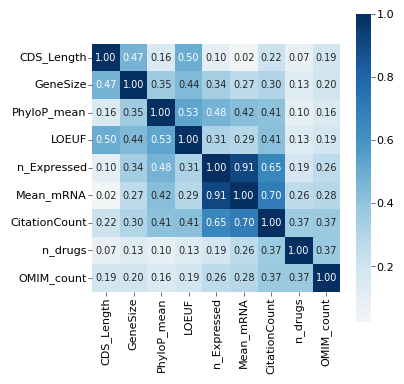

In [21]:
_ = plt.figure(figsize=(4,4))
cg = sns.clustermap(all_features.corr(method='spearman'), figsize=(4,4), cmap='RdBu', center=0)
plt.close()
order= cg.dendrogram_row.reordered_ind[::-1]
sns.heatmap(all_features.corr(method='spearman').iloc[order, order], cmap='RdBu', center=0, square=True, annot=True, fmt='.2f', 
            annot_kws={'fontsize':7})
plt.savefig(os.path.join(figdir, 'FeatureCorrelationsHeatmap.svg'), bbox_inches='tight')


## Data Exploration

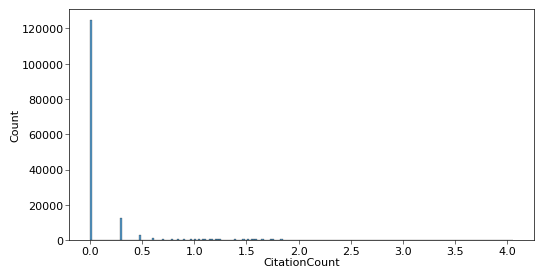

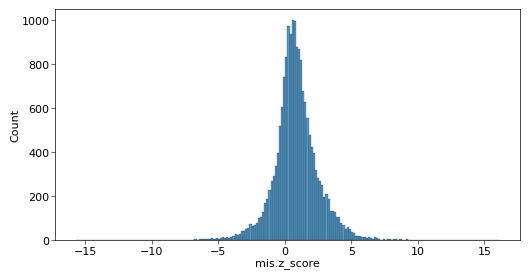

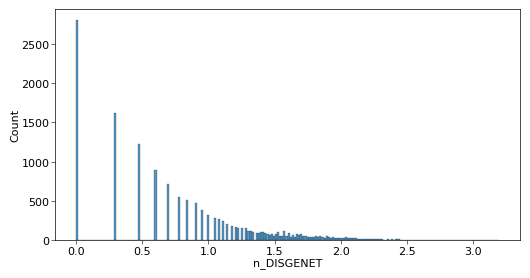

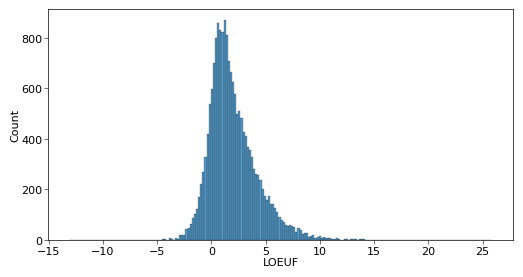

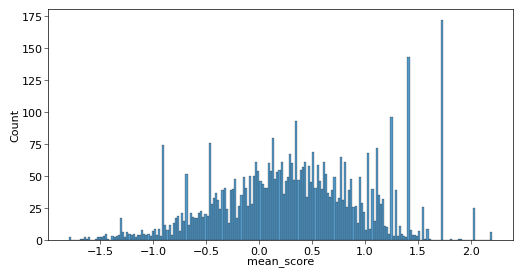

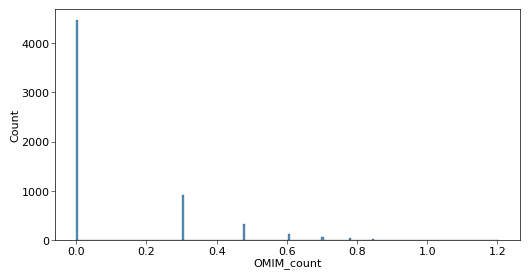

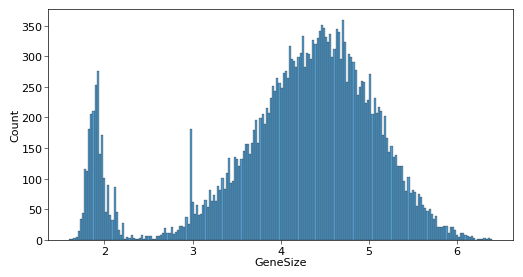

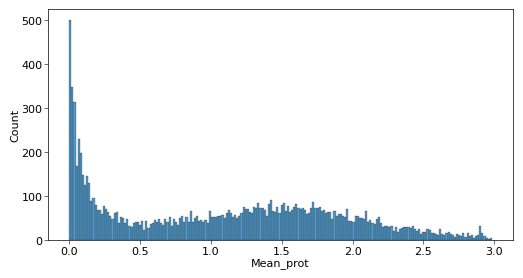

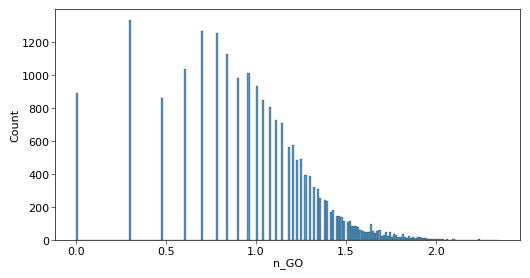

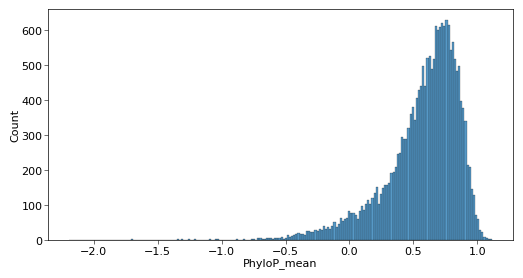

/cellar/users/snwright/anaconda3/envs/carva/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


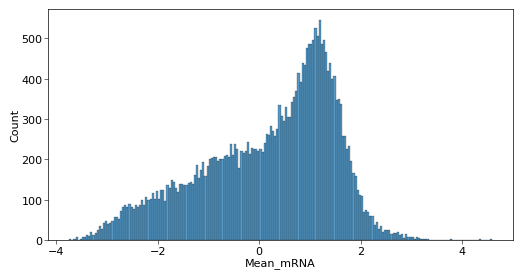

In [22]:
for met, df in annot_dfs.items():
    _ = plt.figure(figsize=(6,3))
    if transform[met] is not None:
        sns.histplot(np.log10(df[usecols[met]]), bins=200)
    else:
        sns.histplot(df[usecols[met]], bins=200)
    plt.show()

### Normality assumptions
Even the most normal looking are not normally distributed. I think I will be better off using non-parametric tests. But should I take the log of exponential variables? Probably?

In [ ]:
from scipy.stats import kstest
from scipy.stats import anderson
from scipy.stats import normaltest # d-angostino and pearson test
import scipy
from scipy.stats import zscore

In [ ]:
annot_dfs['MisSyn'].dropna()['syn.z_score'].values

In [ ]:
zscore(annot_dfs['MisSyn'].dropna()['mis.z_score'].values)

In [ ]:
anderson(zscore(annot_dfs['MisSyn'].dropna()['mis.z_score'].values), dist='norm')

# Input annotations

In [23]:
best_df = pd.read_csv(os.path.join(datadir, 'outputs/netcoloc/March_2025/', 'coloc_repeat_best_results.tsv'), sep='\t')

In [24]:
best_df.TraitC

0      GCST90025947_EFO_0004533
1      GCST90025950_EFO_0005091
2      GCST90019513_EFO_0006925
3      GCST90025956_EFO_0007805
4      GCST90025965_EFO_0004531
                 ...           
368    GCST90239630_EFO_0010967
369      GCST006956_EFO_0004234
370      GCST005010_EFO_1000831
371      GCST001854_EFO_0003839
372    GCST90270216_EFO_0000783
Name: TraitC, Length: 373, dtype: object

In [25]:
r_traitlist = best_df.TraitR.values
c_traitlist = best_df.TraitC.values
len(r_traitlist)

373

## R vs C WSR from all_features

In [30]:
all_features.head()
rgenes = pd.read_csv(os.path.join(datadir,'inputs/March_2025', '34375979_EFO_0004631_RV.txt'), sep='\t').Entrez.unique()

cgenes = pd.read_csv(os.path.join(datadir, 'inputs/March_2025','GCST90239630_EFO_0010967_CV.txt'), sep='\t').Entrez.unique()

In [31]:
from scipy.stats import percentileofscore
percentileofscore(all_features.LOEUF.values)


TypeError: percentileofscore() missing 1 required positional argument: 'score'

In [56]:
res_df.to_csv('/cellar/users/snwright/Data/RareCommon/outputs/Features/best_bio_feature_summarized.txt', sep='\t', index=False)

In [32]:
from scipy.stats import wilcoxon, mannwhitneyu
from statsmodels.stats.multitest import fdrcorrection


def pair_test_annotations(rtraits, ctraits, features):
    all_results = []
    for i, rt in tqdm(enumerate(rtraits)):
        ct = ctraits[i]
        rgenes = pd.read_csv(os.path.join(datadir,'inputs/March_2025', f'{rt}_RV.txt'), sep='\t').Entrez.unique()
        cgenes = pd.read_csv(os.path.join(datadir,'inputs/March_2025',f'{ct}_CV.txt'), sep='\t').Entrez.unique()
        df = get_summary_values(rgenes, cgenes, features)
        df['TraitC'] = ct
        df['TraitR'] = rt
        df['q'] = fdrcorrection(df.p)[1]
        all_results.append(df)
    return pd.concat(all_results)
    
    
def get_summary_values(rgenes, cgenes, all_features):
    all_genes = list(set(rgenes).union(set(cgenes)))
    test_df = all_features.loc[[g for g in all_genes if g in all_features.index.values]]
    rg = [g for g in rgenes if g in test_df.index.values]
    cg= [g for g in cgenes if g in test_df.index.values]
    
    df_r = test_df.loc[rg]
    df_c = test_df.loc[cg]
    p = {}
    for met in df_r.columns:
        
        if (len(df_r.dropna(subset=met)) > 2) and (len(df_c.dropna(subset=met)) > 2):
            p[met] = mannwhitneyu(df_r.dropna(subset=met)[met].values,df_c.dropna(subset=met)[met].values).pvalue
        else:
            p[met] = np.nan
    
    mean_cols = ['OMIM_count', 'n_drugs', 'n_Expressed']
    median_cols = [x for x in test_df.columns if x not in mean_cols]
    mean_r = df_r.mean().loc[mean_cols].to_dict()
    median_r = df_r.median().loc[median_cols].to_dict()
    mean_c = df_c.mean().loc[mean_cols].to_dict()
    median_c = df_c.median().loc[median_cols].to_dict()
    return pd.DataFrame({'R':{**mean_r, **median_r}, 'C': {**mean_c, **median_c},
                        'p': p}).reset_index(names=['metric'])
    
    

In [33]:
res_df = pair_test_annotations(r_traitlist, c_traitlist, all_features)

373it [00:12, 29.56it/s]


In [34]:
from scipy.stats import wilcoxon
pvals = {} 
for x in res_df['metric'].unique():
    print(x)
    pvals[x] = (wilcoxon(res_df[res_df['metric']==x]['C'].values, 
                          res_df[res_df['metric']==x]['R'].values, nan_policy='omit').pvalue)
p_df = pd.DataFrame({'p':pvals})
p_df['q'] = fdrcorrection(p_df.p)[1]

OMIM_count
n_drugs
n_Expressed
CitationCount
LOEUF
GeneSize
PhyloP_mean
CDS_Length
Mean_mRNA


In [35]:
p_df

,p,q
OMIM_count,3.713854e-01,3.713854e-01
n_drugs,3.684975e-05,4.737825e-05
n_Expressed,1.488459e-12,2.679226e-12
CitationCount,6.900783e-14,1.552676e-13
LOEUF,5.969841e-35,2.686428e-34
GeneSize,4.776367e-47,4.298730e-46
PhyloP_mean,3.703258e-16,1.110977e-15
CDS_Length,6.597134e-08,9.895701e-08
Mean_mRNA,1.308236e-01,1.471766e-01


In [37]:
res_df.head()

,metric,R,C,p,TraitC,TraitR,q,EFO
0,OMIM_count,1.2500,1.000000,0.533073,GCST90025947_EFO_0004533,34375979_EFO_0004533,0.748335,EFO_0004533
1,n_drugs,16.3750,22.529412,0.675793,GCST90025947_EFO_0004533,34375979_EFO_0004533,0.748335,EFO_0004533
2,n_Expressed,24.1250,38.058824,0.061393,GCST90025947_EFO_0004533,34375979_EFO_0004533,0.552540,EFO_0004533
3,CitationCount,90.0000,140.000000,0.430986,GCST90025947_EFO_0004533,34375979_EFO_0004533,0.748335,EFO_0004533
4,LOEUF,1.9093,2.852900,0.397642,GCST90025947_EFO_0004533,34375979_EFO_0004533,0.748335,EFO_0004533


In [38]:
res_df = res_df.assign(EFO=res_df.TraitC.apply(lambda x: x.split('_', 1)[-1]))

In [39]:
plot_labels={'OMIM_count':'OMIM', 'n_drugs':'# drugs', 'n_Expressed': '# Tissues', 'CitationCount':'Citations', 'LOEUF':'LOEUF',
       'GeneSize':'Gene Size', 'PhyloP_mean':'PhyloP', 'CDS_Length':'CDS Size', 'Mean_mRNA':'mRNA Exp.'}

In [40]:
res_df = res_df.assign(trait=res_df.TraitR+'_'+res_df.TraitC)

In [41]:
r_vals = res_df.pivot_table(index='trait', columns='metric', values='R').reset_index()
r_vals.index.name=None
r_vals = r_vals.assign(varset='rare')
c_vals= res_df.pivot(index='trait', columns='metric', values='C').reset_index()
c_vals = c_vals.assign(varset='common')
c_vals.index.name=None

In [42]:
all_vals = pd.concat([r_vals, c_vals])
all_vals.to_csv('/cellar/users/snwright/Data/RareCommon/outputs/Features/initial_bio_features.tsv', sep='\t', index=False)

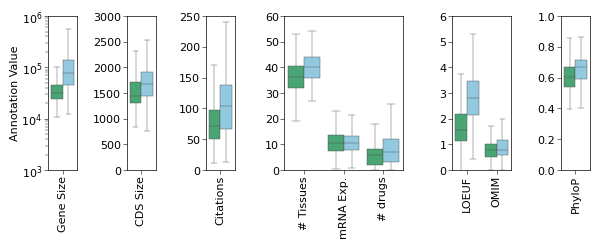

In [43]:
_, [ax1, ax2, ax3, ax4, ax5, ax6] = plt.subplots(nrows=1, ncols=6, figsize=(7, 2), gridspec_kw={'width_ratios':[1,1,1,4,2, 1], 'wspace':1})
res_df['label'] = res_df['metric'].apply(lambda x: plot_labels[x])
sns.boxplot(res_df[res_df['label'].isin(['Gene Size'])].loc[:, ('label', 'R', 'C')].melt(id_vars=['label']), x='label', y='value', 
            hue='variable', fliersize=0, ax=ax1, legend=False, palette=['mediumseagreen', 'skyblue'], log_scale=True, linewidth=0.3)
sns.boxplot(res_df[res_df['label'].isin(['CDS Size', ])].loc[:, ('label', 'R', 'C')].melt(id_vars=['label']), x='label', y='value', 
            hue='variable', fliersize=0, ax=ax2, legend=False, palette=['mediumseagreen', 'skyblue'], log_scale=False, linewidth=0.3)
sns.boxplot(res_df[res_df['label'].isin(['Citations' ])].loc[:, ('label', 'R', 'C')].melt(id_vars=['label']), x='label', y='value', 
            hue='variable', fliersize=0, ax=ax3, legend=False, palette=['mediumseagreen', 'skyblue'], linewidth=0.3)
sns.boxplot(res_df[res_df['label'].isin(['# Tissues', 'mRNA Exp.', '# drugs'])].loc[:, ('label', 'R', 'C')].melt(id_vars=['label']), x='label', y='value', 
            hue='variable', fliersize=0, ax=ax4, legend=False, order=['# Tissues', 'mRNA Exp.', '# drugs'], palette=['mediumseagreen', 'skyblue'], linewidth=0.3)
sns.boxplot(res_df[res_df['label'].isin(['LOEUF', 'OMIM'])].loc[:, ('label', 'R', 'C')].melt(id_vars=['label']), x='label', y='value', 
            hue='variable', fliersize=0, ax=ax5, legend=False, order=['LOEUF', 'OMIM'], palette=['mediumseagreen', 'skyblue'], linewidth=0.3)
sns.boxplot(res_df[res_df['label'].isin(['PhyloP'])].loc[:, ('label', 'R', 'C')].melt(id_vars=['label']), x='label', y='value', 
            hue='variable', fliersize=0, ax=ax6, legend=False, palette=['mediumseagreen', 'skyblue'], linewidth=0.3)
ax1.set_ylim(1000, 1000000)
ax2.set_ylim(0, 3000)
ax3.set_ylim(0, 250)
ax4.set_ylim(0, 60)
ax5.set_ylim(0, 6)
ax6.set_ylim(0, 1)
ax1.set_ylabel('Annotation Value')
ax1.set_xlabel('')
ax1.tick_params(axis='x', rotation=90)
for ax in [ax2, ax3, ax4, ax5, ax6]:
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.tick_params(axis='x', rotation=90)
    
plt.savefig(os.path.join(figdir, 'AnnotationBoxPlots.svg'), bbox_inches='tight')

In [44]:
res_df2 = res_df.copy().dropna(subset='p')
res_df2 = res_df2.assign(q2=fdrcorrection(res_df2.p.values)[1])
res_df2.head()

,metric,R,C,p,TraitC,TraitR,q,EFO,trait,label,q2
0,OMIM_count,1.2500,1.000000,0.533073,GCST90025947_EFO_0004533,34375979_EFO_0004533,0.748335,EFO_0004533,34375979_EFO_0004533_GCST90025947_EFO_0004533,OMIM,0.854640
1,n_drugs,16.3750,22.529412,0.675793,GCST90025947_EFO_0004533,34375979_EFO_0004533,0.748335,EFO_0004533,34375979_EFO_0004533_GCST90025947_EFO_0004533,# drugs,0.928522
2,n_Expressed,24.1250,38.058824,0.061393,GCST90025947_EFO_0004533,34375979_EFO_0004533,0.552540,EFO_0004533,34375979_EFO_0004533_GCST90025947_EFO_0004533,# Tissues,0.448113
3,CitationCount,90.0000,140.000000,0.430986,GCST90025947_EFO_0004533,34375979_EFO_0004533,0.748335,EFO_0004533,34375979_EFO_0004533_GCST90025947_EFO_0004533,Citations,0.786190
4,LOEUF,1.9093,2.852900,0.397642,GCST90025947_EFO_0004533,34375979_EFO_0004533,0.748335,EFO_0004533,34375979_EFO_0004533_GCST90025947_EFO_0004533,LOEUF,0.768605


In [45]:
res_df2 = res_df2.assign(logq= -1 * np.log10(res_df2.q2), minus_logq= np.log10(res_df2.q2))

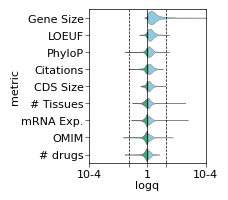

In [46]:
_ = plt.figure(figsize=(1.5, 2))
res_df2 = res_df2.assign(minus_logq = res_df2['logq'] * -1)
sns.violinplot(res_df2[res_df2.C > res_df2.R], y='metric', x='logq', color='skyblue', cut=0, inner=None, 
               density_norm='count', orient='h', linewidth=0.3, order=['GeneSize', 'LOEUF', 'PhyloP_mean', 'CitationCount',
                                                                      'CDS_Length','n_Expressed', 'Mean_mRNA', 'OMIM_count',
                                                                      'n_drugs'])
sns.violinplot(res_df2[res_df2.C<res_df2.R], y='metric', x='minus_logq', color='mediumseagreen', cut=0, inner=None, 
               density_norm='count', orient='h', linewidth=0.3, order=['GeneSize', 'LOEUF', 'PhyloP_mean', 'CitationCount',
                                                                      'CDS_Length','n_Expressed', 'Mean_mRNA', 'OMIM_count',
                                                                      'n_drugs'])
plt.vlines(x=0, ymin=10.5, ymax=-0.5, color='black', linewidth=0.5)
plt.vlines(x=[np.log10(0.05), -1 * np.log10(0.05)], ymin=-0.5, ymax=10.5, linewidth=0.5, linestyle='--', color='black')
plt.ylim(-0.5, 8.5)

plt.gca().invert_yaxis()
_ = plt.xticks([-4, -1.3, 0, 1.3, 4, 10], ['10-4','' , 1,'', '10-4', '10-10'])
plt.xlim(-4, 4)
_ = plt.yticks(plt.yticks()[0], [plot_labels[x.get_text()] for x in plt.yticks()[1]])
plt.savefig(os.path.join(figdir, 'AnnotationViolins.svg'), bbox_inches='tight')

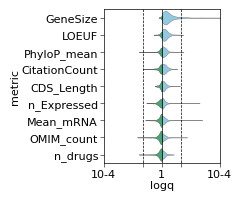

In [47]:
_ = plt.figure(figsize=(1.5, 2))
res_df2 = res_df2.assign(minus_logq = res_df2['logq'] * -1)
sns.violinplot(res_df2[res_df2.C > res_df2.R], y='metric', x='logq', color='skyblue', cut=0, inner=None, 
               density_norm='count', orient='h', linewidth=0.3, order=['GeneSize', 'LOEUF', 'PhyloP_mean', 'CitationCount',
                                                                      'CDS_Length','n_Expressed', 'Mean_mRNA', 'OMIM_count',
                                                                      'n_drugs'])
sns.violinplot(res_df2[res_df2.C<res_df2.R], y='metric', x='minus_logq', color='mediumseagreen', cut=0, inner=None, 
               density_norm='count', orient='h', linewidth=0.3, order=['GeneSize', 'LOEUF', 'PhyloP_mean', 'CitationCount',
                                                                      'CDS_Length','n_Expressed', 'Mean_mRNA', 'OMIM_count',
                                                                      'n_drugs'])
plt.vlines(x=0, ymin=10.5, ymax=-0.5, color='black', linewidth=0.5)
plt.vlines(x=[np.log10(0.05), -1 * np.log10(0.05)], ymin=-0.5, ymax=10.5, linewidth=0.5, linestyle='--', color='black')
plt.ylim(-0.5, 8.5)

plt.gca().invert_yaxis()
_ = plt.xticks([-4, -1.3, 0, 1.3, 4, 10], ['10-4','' , 1,'', '10-4', '10-10'])
plt.xlim(-4, 4)
plt.savefig(os.path.join(figdir, 'AnnotationViolins.svg'), bbox_inches='tight')

## R vs C MannWhitneyU

In [48]:
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import fdrcorrection
def test_annotation(rgenes, cgenes, annot_df, annot_col, metric=np.median, missing_value=None):
    rg = [g for g in rgenes if g in annot_df.dropna(subset=[annot_col]).index.values]
    cg = [g for g in cgenes if g in annot_df.dropna(subset=[annot_col]).index.values]
    if missing_value is None:
        use_df = annot_df.loc[list(rg)+list(cg)]
    else:
        missing = [g for g in rgenes if g not in annot_df.dropna(subset=[annot_col]).index.values] + [g for g in cgenes if g not in annot_df.dropna(subset=[annot_col]).index.values]
        append_df = pd.DataFrame({annot_col: missing_value}, index=missing)
        if len(append_df) > 0:
            use_df = pd.concat([annot_df.loc[list(rg)+list(cg)], append_df])
        else:
            use_df = annot_df.loc[list(rg)+list(cg)]
        rg = rgenes
        cg = cgenes
    if (len(rg) > 0 and len(cg) > 0) and (len(rg) + len(cg) >= 6):
        med_rg = metric(use_df.loc[rg][annot_col].values)
        med_cg = metric(use_df.loc[cg][annot_col].values)
        res = mannwhitneyu(use_df.loc[rg][annot_col].values, use_df.loc[cg][annot_col].values)
    else:
        return {'R_med':np.nan, 'C_med': np.nan, 'p': np.nan}
    return {'R_med':med_rg, 'C_med': med_cg, 'p': res.pvalue}

In [50]:
trait_results = []
for i, rt in tqdm(enumerate(r_traitlist)):
    ct = c_traitlist[i]
    all_res = {}
    rgenes = pd.read_csv(os.path.join(datadir,'inputs/March_2025', f'{rt}_RV.txt'), sep='\t').Entrez.unique()
    cgenes = pd.read_csv(os.path.join(datadir,'inputs/March_2025',f'{ct}_CV.txt'), sep='\t').Entrez.unique()
    for met, df in annot_dfs.items():
        all_res[met] = test_annotation(rgenes, cgenes, df, usecols[met], missing_value = missing_val[met])
    
    all_res = pd.DataFrame.from_dict(all_res,orient='index').reset_index().dropna()
    all_res['CTrait'] = ct
    all_res['RTrait'] = rt
    all_res['q'] = fdrcorrection(all_res.p.values)[1]
    trait_results.append(all_res)

373it [03:02,  2.05it/s]


In [51]:
df = pd.concat(trait_results).sort_values('q')
df['EFO'] = df.CTrait.apply(lambda x: x.split('_', 1)[-1])
df_drop = df.drop_duplicates(subset=['EFO', 'index'])
df_drop = df_drop.assign(logq = -1 * np.log10(df_drop.q))

In [52]:
df['index'].unique()

array(['Length', 'omim', 'mrna', 'Disgen', 'phylop', 'MisSyn', 'pli',
       'GO', 'Cite', 'Prot', 'dgi'], dtype=object)

In [44]:
plot_df = df_drop[df_drop['index']=='pli'].reset_index()
plot_df = plot_df.assign(minus_logq = plot_df['logq'] * -1)
plot_df = plot_df.assign(Cmore=plot_df['R_med'] < plot_df['C_med'])
plot_df = plot_df.assign(sig_level=plot_df.logq.apply(lambda z: 0 if z < 1.3 else 1 if z < 3 else 2 if z < 5 else 3))

### Violin plots

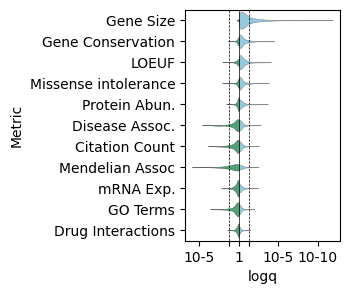

In [15]:
_ = plt.figure(figsize=(2, 3))
df_drop = df_drop.assign(minus_logq = df_drop['logq'] * -1)
plot_df = df_drop.assign(Metric=df_drop['index'].map(labels))
sns.violinplot(plot_df[plot_df.C_med > plot_df.R_med], y='Metric', x='logq', color='skyblue', cut=0, inner=None, 
               density_norm='count', orient='h', linewidth=0.3)
sns.violinplot(plot_df[plot_df.C_med < plot_df.R_med], y='Metric', x='minus_logq', color='mediumseagreen', cut=0, inner=None, 
               density_norm='count', orient='h', linewidth=0.3)
plt.vlines(x=0, ymin=10.5, ymax=-0.5, color='black', linewidth=0.5)
plt.vlines(x=[np.log10(0.05), -1 * np.log10(0.05)], ymin=-0.5, ymax=10.5, linewidth=0.5, linestyle='--', color='black')
plt.ylim(-0.5, 10.5)
plt.gca().invert_yaxis()
_ = plt.xticks([-5, -1.3, 0, 1.3, 5, 10], ['10-5','' , 1,'', '10-5', '10-10'])

In [83]:
plot_df.to_csv('/cellar/users/snwright/Data/RareCommon/outputs/Features/initial_bio_features.tsv', sep='\t', index=False)

## Paired Wilcoxon on medians/means

In [45]:
from scipy.stats import wilcoxon
pvals = [] 
for x in df_drop['index'].unique():
    print(x)
    pvals.append(wilcoxon(df_drop[df_drop['index']==x]['C_med'].values, df_drop[df_drop['index']==x]['R_med'].values, nan_policy='omit').pvalue)
    
fdrcorrection(pvals, alpha=0.05)

Length
phylop
Cite
Disgen
GO
pli
omim
MisSyn
mrna
Prot
dgi


In [46]:
fdrcorrection(pvals, alpha=0.05)

(array([ True,  True,  True,  True,  True,  True, False,  True, False,
        False,  True]),
 array([1.36471054e-40, 8.66315977e-14, 7.02818324e-06, 1.25337067e-03,
        3.73063259e-06, 8.11268224e-20, 7.12484085e-01, 2.46729150e-12,
        7.12484085e-01, 6.77720587e-01, 3.85679452e-02]))

## Additional metrics

In [22]:
transform = {
 'MisSyn': None,
 'pli': None,
 'dgi': np.log10,
 'Prot': None,
 'phylop': None,
 'mrna': np.log10,
    'pli_z': None,
 'drug': None}

metric = {
 'MisSyn': np.mean,
 'pli': np.median,
 'dgi': np.mean,
 'Prot': np.median,
 'phylop': np.median,
 'mrna': np.median,
    'pli_z': np.median,
 'drug': np.mean}

missing_val = {
 'MisSyn': None,
 'pli': None,
 'dgi': 0,
 'Prot': None,
 'phylop': None,
 'mrna': None,
'pli_z': None,
 'drug': 0}

usecols = {
 'MisSyn': 'syn.z_score',
 'pli': 'lof.pLI',
 'dgi': 'n_drugs',
 'Prot': 'n_Expressed',
 'phylop': 'PhyloP_median',
 'mrna': 'n_Expressed',
 'pli_z': 'lof.z_score',
 'drug': 'druggability'}

labels = {
 'MisSyn': 'Synonymous intolerance',
 'pli': 'lof.pLI',
 'dgi': 'Drug Count',
 'Prot': 'Protein Abun.',
 'phylop': 'Gene Conservation',
 'mrna': 'mRNA Exp.',
  'pli_z': 'lof.z_score',
 'drug': 'druggability'}

files = {
    'MisSyn': 'Gene_MisSyn.txt', 
    'pli': 'Gene_pLI.txt',
    'dgi': 'Gene_DGI_scores.txt', 
    'Prot': 'Gene_prot.txt',
    'phylop': 'Gene_PhyloP.txt',
    'mrna':'Gene_mRNA.txt',
        'pli_z': 'Gene_pLI.txt',
    'drug': 'Gene_DGI_scores.txt', 
}

annot_dfs2 = {}
for met, file in files.items():
    annot_dfs2[met] = pd.read_csv(os.path.join(annot_dir, file), sep='\t', index_col=0)

In [23]:
trait_results2 = []
for i, rt in tqdm(enumerate(r_traitlist[0:400])):
    ct = c_traitlist[i]
    all_res = {}
    rgenes = pd.read_csv(os.path.join(datadir,'inputs/Jan_2025', f'{rt}_RV.txt'), sep='\t').Entrez.unique()
    cgenes = pd.read_csv(os.path.join(datadir,'inputs/Jan_2025',f'{ct}_CV.txt'), sep='\t').Entrez.unique()
    for met, df in annot_dfs2.items():
        all_res[met] = test_annotation(rgenes, cgenes, df, usecols[met], missing_value = missing_val[met])
    
    all_res = pd.DataFrame.from_dict(all_res,orient='index').reset_index().dropna()
    all_res['CTrait'] = ct
    all_res['RTrait'] = rt
    all_res['q'] = fdrcorrection(all_res.p.values)[1]
    trait_results2.append(all_res)

400it [03:12,  2.08it/s]


In [24]:
df2 = pd.concat(trait_results2).sort_values('q')
df2['EFO'] = df2.CTrait.apply(lambda x: x.split('_', 1)[-1])
df2_drop = df2.drop_duplicates(subset=['EFO', 'index'])
df2_drop = df2_drop.assign(logq = -1 * np.log10(df2_drop.q))

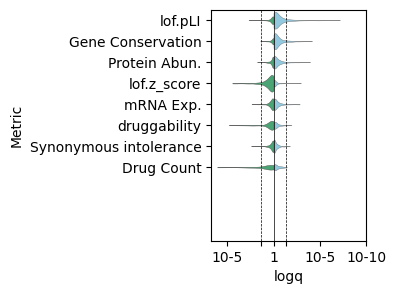

In [25]:
_ = plt.figure(figsize=(2, 3))
df2_drop = df2_drop.assign(minus_logq = df2_drop['logq'] * -1)
plot_df = df2_drop.assign(Metric=df2_drop['index'].map(labels))
sns.violinplot(plot_df[plot_df.C_med > plot_df.R_med], y='Metric', x='logq', color='skyblue', cut=0, inner=None, 
               density_norm='count', orient='h', linewidth=0.3)
sns.violinplot(plot_df[plot_df.C_med < plot_df.R_med], y='Metric', x='minus_logq', color='mediumseagreen', cut=0, inner=None, 
               density_norm='count', orient='h', linewidth=0.3)
plt.vlines(x=0, ymin=10.5, ymax=-0.5, color='black', linewidth=0.5)
plt.vlines(x=[np.log10(0.05), -1 * np.log10(0.05)], ymin=-0.5, ymax=10.5, linewidth=0.5, linestyle='--', color='black')
plt.ylim(-0.5, 10.5)
plt.gca().invert_yaxis()
_ = plt.xticks([-5, -1.3, 0, 1.3, 5, 10], ['10-5','' , 1,'', '10-5', '10-10'])

# Network Annotations

In [47]:
all_pairs = [r_traitlist[i]+'_'+c_traitlist[i] for i in range(len(r_traitlist))]
len(all_pairs)

336

In [48]:
# Load network results
net = []
for pair in all_pairs:
    try:
        x = pd.read_csv(os.path.join(datadir, 'outputs/Features', f'network_stats_pcnet2_0_rare.traitlist2.{pair}'), sep='\t', low_memory=False)
        net.append(x)
    except FileNotFoundError:
        print(f'{pair} not found')

In [49]:
netdf = pd.concat(net)

In [50]:
mod_df = pd.read_csv(os.path.join(datadir, 'outputs/Features/network_modularities_pcnet2_2_rare.traitlist2'), sep='\t')

In [51]:
mod_df.index = all_pairs

In [52]:
mod_df.columns = ['common', 'rare', 'overlap', 'subnetwork?', 'rare_common']

In [53]:
mod_df = mod_df.melt(value_name='Modularity', var_name='varset', ignore_index=False).reset_index(names='trait')

In [54]:
mod_df.head()

,trait,varset,Modularity
0,34375979.0_EFO_0009322_GCST007289_EFO_0009322,common,-3.362651e-08
1,34375979.0_EFO_0007997_GCST004608_EFO_0007997,common,4.296145e-05
2,34375979.0_EFO_0009959_GCST008105_EFO_0009959,common,5.995276e-07
3,34662886.0_EFO_0009819_GCST010989_EFO_0009819,common,5.622304e-05
4,36809768.0_EFO_0010114_GCST90092813_EFO_0010114,common,2.226009e-07


In [55]:
# get gene set sizes

over_df = pd.read_csv('/cellar/users/snwright/Data/RareCommon/outputs/overlap/rvc_overlap_results_Jan_2025_v2.txt', sep='\t',
                     header=None, names=['trait_pair', 'param_set', 'n_common', 'n_rare', 'n_overlap', 'background', 'pval'])
over_df = over_df[over_df.trait_pair.isin(all_pairs)]
size_df = over_df.loc[:, ('trait_pair','n_common', 'n_rare', 'n_overlap')]
size_df = size_df.assign(total=size_df.n_common + size_df.n_rare - 2 * size_df.n_overlap)

In [56]:
size_df = size_df.melt(id_vars='trait_pair', var_name='varset', value_name='SetSize')

In [57]:
size_df = size_df.assign(varset=size_df.varset.map({'n_common':'common', 'n_rare':'rare', 'n_overlap':'overlap', 'total':'rare_common'}))

In [58]:
size_df.head()

,trait_pair,varset,SetSize
0,20549515.0_EFO_0000384_GCST90446792_EFO_0000384,common,102
1,20549515.0_EFO_0000685_GCST90018910_EFO_0000685,common,11
2,20691247.0_EFO_0004825_GCST001531_EFO_0004825,common,6
3,20876667.0_EFO_0000765_GCST001060_EFO_0000765,common,3
4,23263489.0_EFO_0009961_GCST008110_EFO_0009961,common,3


In [59]:
netdf = netdf.merge(size_df, left_on=['trait','varset'], right_on=['trait_pair', 'varset'], how='left')

In [684]:
mod_df.head()

,Modularity,varset
0,common,-3.362651e-08
1,common,4.296145e-05
2,common,5.995276e-07
3,common,5.622304e-05
4,common,2.226009e-07


In [60]:
netdf = netdf.merge(mod_df, on=['trait', 'varset'])

In [61]:
netdf = netdf.drop(columns=['trait_pair'])

In [62]:
netdf.head()

,trait,varset,subnetwork_density,n_components,average_degree,subnetwork_average_degree,clustering,subnetwork_clustering,assortativity,average_path,subnetwork_assortativity,SetSize,Modularity
0,34375979.0_EFO_0009322_GCST007289_EFO_0009322,rare,0.0,4,362.250000,0.0,0.245490,0.0,-0.000188,2.333333,NaN,4.0,-6.005819e-08
1,34375979.0_EFO_0009322_GCST007289_EFO_0009322,common,0.0,7,166.142857,0.0,0.279579,0.0,-0.000151,2.571429,NaN,7.0,-3.362651e-08
2,34375979.0_EFO_0009322_GCST007289_EFO_0009322,overlap,0.0,0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,NaN,0.0,0.000000e+00
3,34375979.0_EFO_0009322_GCST007289_EFO_0009322,rare_common,0.0,11,237.454545,0.0,0.269090,0.0,-0.000339,2.454545,0.0,11.0,-1.835635e-07
4,34375979.0_EFO_0007997_GCST004608_EFO_0007997,rare,0.0,11,285.000000,0.0,0.257782,0.0,-0.000407,2.672727,NaN,11.0,-3.175640e-07


## Feature Correlations

In [63]:
netdf.head()

,trait,varset,subnetwork_density,n_components,average_degree,subnetwork_average_degree,clustering,subnetwork_clustering,assortativity,average_path,subnetwork_assortativity,SetSize,Modularity
0,34375979.0_EFO_0009322_GCST007289_EFO_0009322,rare,0.0,4,362.250000,0.0,0.245490,0.0,-0.000188,2.333333,NaN,4.0,-6.005819e-08
1,34375979.0_EFO_0009322_GCST007289_EFO_0009322,common,0.0,7,166.142857,0.0,0.279579,0.0,-0.000151,2.571429,NaN,7.0,-3.362651e-08
2,34375979.0_EFO_0009322_GCST007289_EFO_0009322,overlap,0.0,0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,NaN,0.0,0.000000e+00
3,34375979.0_EFO_0009322_GCST007289_EFO_0009322,rare_common,0.0,11,237.454545,0.0,0.269090,0.0,-0.000339,2.454545,0.0,11.0,-1.835635e-07
4,34375979.0_EFO_0007997_GCST004608_EFO_0007997,rare,0.0,11,285.000000,0.0,0.257782,0.0,-0.000407,2.672727,NaN,11.0,-3.175640e-07


In [64]:
initial_features = ['SetSize', 'average_path', 'subnetwork_clustering', 'average_degree', 'clustering', 'Modularity']

corr_df = netdf.loc[netdf.varset.isin(['rare', 'common']), ['trait', 'varset']+initial_features]

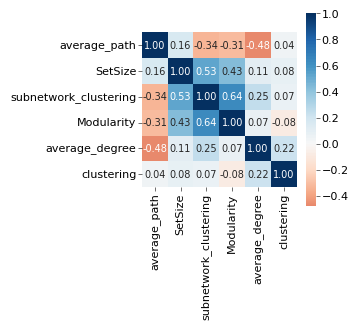

In [66]:
_ = plt.figure(figsize=(2.5,2.5))
cg = sns.clustermap(corr_df.corr(numeric_only=True, method='spearman'), figsize=(4,4), cmap='RdBu', center=0)
plt.close()
order= cg.dendrogram_row.reordered_ind
sns.heatmap(corr_df.corr(numeric_only=True, method='spearman').iloc[order, order], cmap='RdBu', center=0, square=True, annot=True, fmt='.2f', 
            annot_kws={'fontsize':7})
plt.savefig(os.path.join(figdir, 'FeatureCorrelationsHeatmap_network.svg'), bbox_inches='tight')

In [72]:
plot_df = netdf.loc[netdf.varset.isin(['rare', 'common']), ['trait', 'varset']+initial_features].melt(id_vars=['trait', 'varset'], var_name='metric')
plot_df.head()

,trait,varset,metric,value
0,34375979.0_EFO_0009322_GCST007289_EFO_0009322,rare,SetSize,4.0
1,34375979.0_EFO_0009322_GCST007289_EFO_0009322,common,SetSize,7.0
2,34375979.0_EFO_0007997_GCST004608_EFO_0007997,rare,SetSize,11.0
3,34375979.0_EFO_0007997_GCST004608_EFO_0007997,common,SetSize,89.0
4,34375979.0_EFO_0009959_GCST008105_EFO_0009959,rare,SetSize,65.0


In [73]:
plot_df.sort_values('value', ascending=False).head()

,trait,varset,metric,value
2301,26264438.0_EFO_0000519_GCST003220_EFO_0000519,common,average_degree,2007.750000
2140,34662886.0_MONDO_0004992_GCST90267270_MONDO_00...,rare,average_degree,1951.666667
2153,34375979.0_EFO_1000726_GCST90435153_EFO_1000726,common,average_degree,1755.000000
2072,34662886.0_EFO_0000095_GCST90027053_EFO_0000095,rare,average_degree,1695.428571
2200,31242253.0_GO_0036273_GCST000635_GO_0036273,rare,average_degree,1686.800000


## Feature Values

In [68]:
# get network averages
path_sum = pd.read_csv(os.path.join(datadir, 'outputs/Features', 'pcnet2_0path_lengths.csv'), index_col=0).sum().sum()
mean_path = path_sum / (19267**2 -19267)
print(mean_path)

2.3892726615876203


In [69]:
mean_clust = pd.read_csv(os.path.join(datadir, 'outputs/Features', 'pcnet2_0_clustering_coefficients.csv'), index_col=0).mean().values[0]
print(mean_clust)

0.30505576232614184


In [70]:
mean_degree = pd.read_csv(os.path.join(datadir, 'inputs', 'pcnet2_0_nodes.txt'), header=None, index_col=0, sep='\t').mean().values[0]
mean_degree

399.8670265220325

In [71]:
initial_features

['SetSize',
 'average_path',
 'subnetwork_clustering',
 'average_degree',
 'clustering',
 'Modularity']

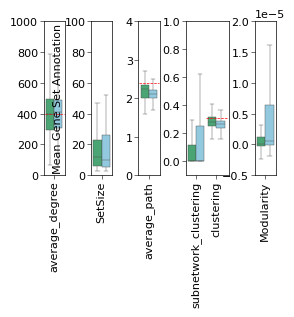

In [76]:
_, [ax1, ax2, ax3, ax4, ax5] = plt.subplots(ncols=5, nrows=1, figsize=(3, 2), gridspec_kw={'width_ratios':[1,1,1,2,1], 'wspace':1})
sns.boxplot(plot_df[plot_df.metric=='average_degree'], x='metric', y='value', hue='varset', ax=ax1, legend=False,
           fliersize=0, palette=['mediumseagreen', 'skyblue'], hue_order=['rare', 'common'], linewidth=0.3)
ax1.hlines(y=mean_degree, xmin=-0.5, xmax=0.5, color='red', linestyle='--', linewidth=0.5)
sns.boxplot(plot_df[plot_df.metric=='SetSize'], x='metric', y='value', hue='varset', ax=ax2, linewidth=0.3
            , legend=False, fliersize=0,palette=['mediumseagreen', 'skyblue'], hue_order=['rare', 'common'])
sns.boxplot(plot_df[plot_df.metric.isin([ 'average_path'])], x='metric', y='value', 
            hue='varset', palette=['mediumseagreen', 'skyblue'], hue_order=['rare', 'common'],
            ax=ax3, fliersize=0, legend=False, linewidth=0.3)
ax3.hlines(y=mean_path, xmin=-0.5, xmax=0.5, color='red', linestyle='--', linewidth=0.5)
sns.boxplot(plot_df[~plot_df.metric.isin(['average_degree', 'average_path', 'SetSize', 'Modularity'])], 
            x='metric', y='value', hue='varset', palette=['mediumseagreen', 'skyblue'], hue_order=['rare', 'common'],
            ax=ax4, fliersize=0, legend=False, linewidth=0.3)
sns.boxplot(plot_df[plot_df.metric.isin(['Modularity'])], 
            x='metric', y='value', hue='varset', palette=['mediumseagreen', 'skyblue'], hue_order=['rare', 'common'],
            ax=ax5, fliersize=0, legend=False, linewidth=0.3)
ax4.hlines(y=mean_clust, xmin=0.5, xmax=1.5, color='red', linestyle='--', linewidth=0.5)
ax1.set_ylim(0, 1000)
ax2.set_ylim(0, 100)
ax3.set_ylim(0, 4)
ax4.set_ylim(-0.1, 1)
ax5.set_ylim(-0.000005, 0.00002)
for ax in [ax1, ax2, ax3, ax4, ax5]:
    ax.tick_params(axis='x',rotation=90)
    ax.set_xlabel('')
    ax.set_ylabel('')
_ = ax2.set_ylabel('Mean Gene Set Annotation')
plt.savefig(os.path.join(figdir, 'BoxPlots_NetAnno.svg'), bbox_inches='tight')

In [715]:
rc_netdf = netdf[netdf.varset.isin(['rare', 'common'])].melt(id_vars=['trait', 'varset'], var_name='metric').pivot(index=['trait', 'metric'], columns='varset')
rc_netdf.columns = [x[1] for x in rc_netdf.columns]
rc_netdf = rc_netdf.reset_index()
rc_netdf['common'] = rc_netdf['common'].astype(float)
rc_netdf['rare'] = rc_netdf['rare'].astype(float)

In [716]:
from scipy.stats import wilcoxon
pvals = {} 
for x in rc_netdf['metric'].unique():
    if x in initial_features:
        pvals[x] = (wilcoxon(rc_netdf[rc_netdf['metric']==x]['common'].values, 
                          rc_netdf[rc_netdf['metric']==x]['rare'].values, nan_policy='omit').pvalue)
p_net = pd.DataFrame({'p':pvals})
p_net['q'] = fdrcorrection(p_net.p)[1]

In [717]:
p_net

,p,q
Modularity,2.404778e-15,1.442867e-14
SetSize,7.008944e-01,7.008944e-01
average_degree,6.685117e-01,7.008944e-01
average_path,3.815042e-05,1.098563e-04
clustering,8.809589e-05,1.321438e-04
subnetwork_clustering,5.492814e-05,1.098563e-04


In [79]:
netdf.to_csv('/cellar/users/snwright/Data/RareCommon/outputs/Features/initial_net_features.tsv', sep='\t', index=False)

# Coloc annotations

## Let's just look at some correlations

In [ ]:
import obonet as obo
efo = obo.read_obo('http://www.ebi.ac.uk/efo/efo.obo')
efo_root='EFO:0000001'

In [660]:
all_efo = [':'.join(x.split('_')[1:3]) for x in all_pairs]

In [662]:
efo.nodes[all_efo[12]]['name']

'aconitate measurement'

In [ ]:
# import coloc results

In [649]:
coloc_df = pd.read_csv(os.path.join(datadir, 'outputs/netcoloc', 'prelim_coloc_results.tsv'), sep='\t')

(318, 23)